In [1]:
import pandas as pd
import xml.etree.ElementTree as ET
import numpy as np
import math as math
import matplotlib.pyplot as plt

# Variables

In [2]:
lowerLimit = -70 #Lower limit of rssi acceptance values
limit_number = 2 #The accepted lower limit of rssi from matching mac addresses of the same coordinate as a result of multiple scans.
#i.e when averaging rssi, if the denominator is <= 1, remove it.


## Grid Data

In [3]:
gridData = ET.parse("Grid-Data10.xml")

In [4]:
gridDataRoot = gridData.getroot()

In [5]:
class GridPoint:
    def __init__(self, X, Y, df=None):
        self.X = X
        self.Y = Y
        if df is None:
            df = None
        else:
            self.df = df
    def __str__(self):
        return f"{self.X}, {self.Y}. {self.df}"
    def __repr__(self):
        return self.__str__()

In [6]:
#Creates a list of grid points for every grid point received from data

gridPointsList = []
for grid in gridDataRoot:
    X = grid.find("X").text
    Y = grid.find("Y").text
    data = []

    for wifiPoint in grid.find("wifi"):
        if (int(wifiPoint.text) < lowerLimit):
            continue
        
        data.append({"mac_ad": wifiPoint.attrib.get("mac_ad"), 
             "rssi": int(wifiPoint.text), 
             "ssid": wifiPoint.attrib.get("ssid")})
    df = pd.DataFrame(data)
    gridPointsList.append(GridPoint(X, Y, df))
    
    
gridPointsList

[3.0, -3.0.               mac_ad  rssi          ssid
 0  a0:b4:39:33:29:ed   -52  UCD Wireless
 1  a0:b4:39:33:29:e2   -59  UCD Wireless
 2  a0:b4:39:33:29:e1   -59       eduroam
 3  a0:b4:39:33:29:ee   -53       eduroam
 4  3c:51:0e:ac:e9:01   -69       eduroam
 5  3c:51:0e:ac:e9:02   -69  UCD Wireless,
 3.0, -3.0.               mac_ad  rssi          ssid
 0  a0:b4:39:33:29:ed   -52  UCD Wireless
 1  a0:b4:39:33:29:ee   -53       eduroam
 2  3c:51:0e:ac:e9:01   -69       eduroam
 3  3c:51:0e:ac:e9:02   -69  UCD Wireless,
 3.0, -3.0.               mac_ad  rssi          ssid
 0  a0:b4:39:33:29:ed   -55  UCD Wireless
 1  a0:b4:39:33:29:e2   -59  UCD Wireless
 2  a0:b4:39:33:29:e1   -59       eduroam
 3  a0:b4:39:33:29:ee   -53       eduroam,
 3.0, -3.0.               mac_ad  rssi          ssid
 0  a0:b4:39:33:29:ed   -55  UCD Wireless
 1  a0:b4:39:33:29:e2   -59  UCD Wireless
 2  a0:b4:39:33:29:e1   -59       eduroam
 3  a0:b4:39:33:29:ee   -53       eduroam,
 3.0, -3.0.               ma

In [7]:
####Averages rssi of matching mac address for each grid point

#Adds or appends rssi values to mac address keys
def wifiToDict(row, Dict):
    #if mac_ad is already in dict, then append the rssi, else add the mac_ad
    if (row["mac_ad"] in Dict):
        Dict.get(row["mac_ad"]).append(row["rssi"])
    else:
         Dict[row["mac_ad"]] = [row["rssi"]]

currX = gridPointsList[0].X
currY = gridPointsList[0].Y
gridCoordsList = [GridPoint(currX, currY)]
wifi_dict = {}
dictionariedGridPointsList = []
#Makes a list of dictionaries that have a list of rssis from matching coords and matching mac addresses
for i in range(len(gridPointsList)):
    if ((currX == gridPointsList[i].X and currY == gridPointsList[i].Y) == False):
        dictionariedGridPointsList.append(wifi_dict)
        wifi_dict = {}
        currX = gridPointsList[i].X
        currY = gridPointsList[i].Y
        gridCoordsList.append(GridPoint(currX, currY))
    
    df = gridPointsList[i].df
    for j, row in df.iterrows():
        wifiToDict(row, wifi_dict)
        
dictionariedGridPointsList.append(wifi_dict)
#print(dictionariedGridPointsList)


#Averages the list of rssis for each mac address
averagedGridPointsList = []
for i in range(len(dictionariedGridPointsList)):
        
    temp_dict = {}
    for item in dictionariedGridPointsList[i].items():
        if (len(item[1]) > limit_number):
            temp_dict[item[0]] =  sum(item[1])/len(item[1])
        else:
            dictionariedGridPointsList[i].pop(item[0])
            break
        #print(f"{i}, {item[0]}, {item[1]}")
    
    mac_ads = temp_dict.keys()
    rssis = temp_dict.values()
    averagedGridPointsList.append(GridPoint(gridCoordsList[i].X, gridCoordsList[i].Y, pd.DataFrame(list(zip(mac_ads, rssis)), columns=["mac_ad", "rssi"])))  
    
averagedGridPointsList[27].df

,mac_ad,rssi
0,a0:b4:39:33:29:ed,-62.000000
1,a0:b4:39:33:29:e2,-64.333333
2,a0:b4:39:33:29:e1,-64.333333
3,a0:b4:39:33:29:ee,-59.333333


## Trial Data (Acceleration, heading etc)

In [8]:
data = ET.parse("Trial10.xml")
TrialDataRoot = data.getroot()

In [9]:
dataPointsList = []
for dataPoint in TrialDataRoot:
    wifi = []
    for wifiPoint in dataPoint.find("wifi"):
        if (int(wifiPoint.text) < lowerLimit):
            continue
        wifi.append({"mac_ad": wifiPoint.attrib.get("mac_ad"), 
         "rssi": int(wifiPoint.text), 
         "ssid": wifiPoint.attrib.get("ssid")})
        
    dataPointsList.append(
        {
            "Acceleration": float(dataPoint.find("acceleration").text),
            "Heading": float(dataPoint.find("heading").text),
            "Timestamp": float(dataPoint.find("timestamp").text),
            "Wifi": wifi
        }
    )
    
df = pd.DataFrame(dataPointsList)

In [10]:
#Modifying Data
df["Time Elapsed"] = ((df["Timestamp"]-df["Timestamp"][0])/1000000)
df["Acceleration"] = df["Acceleration"]-9.8
df["Heading"] = df["Heading"] - df["Heading"][0]
df

,Acceleration,Heading,Timestamp,Wifi,Time Elapsed
0,-0.232228,0.000000,5.574053e+12,[],0.000000
1,0.333068,0.073541,5.574072e+12,[],19.057002
2,0.532064,0.022184,5.574091e+12,[],38.113920
3,0.772587,-0.093608,5.574110e+12,[],57.171096
4,0.760338,-0.231243,5.574129e+12,[],76.228112
...,...,...,...,...,...
1548,-2.128944,-185.977957,5.603553e+12,[],29500.098645
1549,-1.510123,-185.672361,5.603572e+12,[],29519.155594
1550,-0.899961,-185.230250,5.603591e+12,[],29538.212582
1551,-0.658768,-184.659143,5.603610e+12,[],29557.269478


# Predicting Coordinates

In [11]:
wifi_data = df[df["Wifi"].str.len() != 0]
wifi_data

,Acceleration,Heading,Timestamp,Wifi,Time Elapsed
262,-0.035532,7.340404,5.579046e+12,"[{'mac_ad': 'a0:b4:39:33:29:ed', 'rssi': -54, ...",4992.954302
472,0.043977,-4.484265,5.583048e+12,"[{'mac_ad': 'a0:b4:39:33:29:ed', 'rssi': -56, ...",8994.924693
682,-0.465975,4.930809,5.587050e+12,"[{'mac_ad': 'a0:b4:39:33:29:ed', 'rssi': -56, ...",12996.876850
892,2.395739,18.108191,5.591051e+12,"[{'mac_ad': 'a0:b4:39:33:29:ed', 'rssi': -51, ...",16998.817827
1102,-0.777061,-185.868387,5.595053e+12,"[{'mac_ad': 'a0:b4:39:33:29:ed', 'rssi': -51, ...",21000.752446
1312,0.947411,-209.049558,5.599055e+12,"[{'mac_ad': 'a0:b4:39:33:29:ed', 'rssi': -56, ...",25002.683207
1522,0.198639,-184.154509,5.603057e+12,"[{'mac_ad': 'a0:b4:39:33:29:ed', 'rssi': -56, ...",29004.617586


In [12]:
#Number K in KNN
K = 3
ListInUse = averagedGridPointsList#options: gridPointsList or averagedGridPointsList
#Go Through all the Data Points
for i, dataPoint in wifi_data.iterrows():
    #Collect the cumulative error between every dataPoint and gridPoint
    errors = []
    for gridPoint in gridPointsList:
        #Converting corressponding points to key-value pair data structure with mac_ad as key and rssi as value
        grid_dict = gridPoint.df.set_index("mac_ad").to_dict()["rssi"]
        data_dict = pd.DataFrame(dataPoint["Wifi"]).set_index("mac_ad").to_dict()["rssi"]
        
        #Calculate Cumulative Error
        error = 0
        for key, value in data_dict.items():
            if key in grid_dict:#If keys match, calculate difference and add to cumultive error. #Ignore keys that don't match
                error += abs(int(grid_dict[key]) - int(value))
            else: error += 100
        errors.append({"error": error,
                      "X": gridPoint.X,
                      "Y": gridPoint.Y})
    
    #Sort list by the ascending error
    sorted_list = sorted(errors, key=lambda k: k["error"])
    sorted_list = sorted_list[0:K]
    print(sorted_list)
    
    #Calculate Average distance between the 3 grid points of least error
    x = 0
    y = 0
    for point in sorted_list:
        x += float(point["X"])
        y += float(point["Y"])
    x /= K
    y /= K
    
    #Put Predicted coordinates into original data df
    df.at[i, "Predicted X"] = x
    df.at[i, "Predicted Y"] = y
    print(f"Predicted Coordinates: {x},{y}\n\n")

completed_df = df
completed_df

[{'error': 13, 'X': '1.0', 'Y': '-1.0'}, {'error': 13, 'X': '0.0', 'Y': '-1.0'}, {'error': 16, 'X': '0.0', 'Y': '-1.0'}]
Predicted Coordinates: 0.3333333333333333,-1.0


[{'error': 4, 'X': '3.0', 'Y': '-1.0'}, {'error': 5, 'X': '3.0', 'Y': '-3.0'}, {'error': 5, 'X': '1.0', 'Y': '0.0'}]
Predicted Coordinates: 2.3333333333333335,-1.3333333333333333


[{'error': 4, 'X': '3.0', 'Y': '-1.0'}, {'error': 5, 'X': '3.0', 'Y': '-3.0'}, {'error': 5, 'X': '1.0', 'Y': '0.0'}]
Predicted Coordinates: 2.3333333333333335,-1.3333333333333333


[{'error': 2, 'X': '0.0', 'Y': '-2.0'}, {'error': 2, 'X': '0.0', 'Y': '-2.0'}, {'error': 3, 'X': '0.0', 'Y': '-2.0'}]
Predicted Coordinates: 0.0,-2.0


[{'error': 2, 'X': '0.0', 'Y': '-2.0'}, {'error': 2, 'X': '0.0', 'Y': '-2.0'}, {'error': 3, 'X': '0.0', 'Y': '-2.0'}]
Predicted Coordinates: 0.0,-2.0


[{'error': 3, 'X': '0.0', 'Y': '-3.0'}, {'error': 3, 'X': '-2.0', 'Y': '-2.0'}, {'error': 3, 'X': '-2.0', 'Y': '-2.0'}]
Predicted Coordinates: -1.3333333333333333,-

,Acceleration,Heading,Timestamp,Wifi,Time Elapsed,Predicted X,Predicted Y
0,-0.232228,0.000000,5.574053e+12,[],0.000000,NaN,NaN
1,0.333068,0.073541,5.574072e+12,[],19.057002,NaN,NaN
2,0.532064,0.022184,5.574091e+12,[],38.113920,NaN,NaN
3,0.772587,-0.093608,5.574110e+12,[],57.171096,NaN,NaN
4,0.760338,-0.231243,5.574129e+12,[],76.228112,NaN,NaN
...,...,...,...,...,...,...,...
1548,-2.128944,-185.977957,5.603553e+12,[],29500.098645,NaN,NaN
1549,-1.510123,-185.672361,5.603572e+12,[],29519.155594,NaN,NaN
1550,-0.899961,-185.230250,5.603591e+12,[],29538.212582,NaN,NaN
1551,-0.658768,-184.659143,5.603610e+12,[],29557.269478,NaN,NaN


# Step Detection

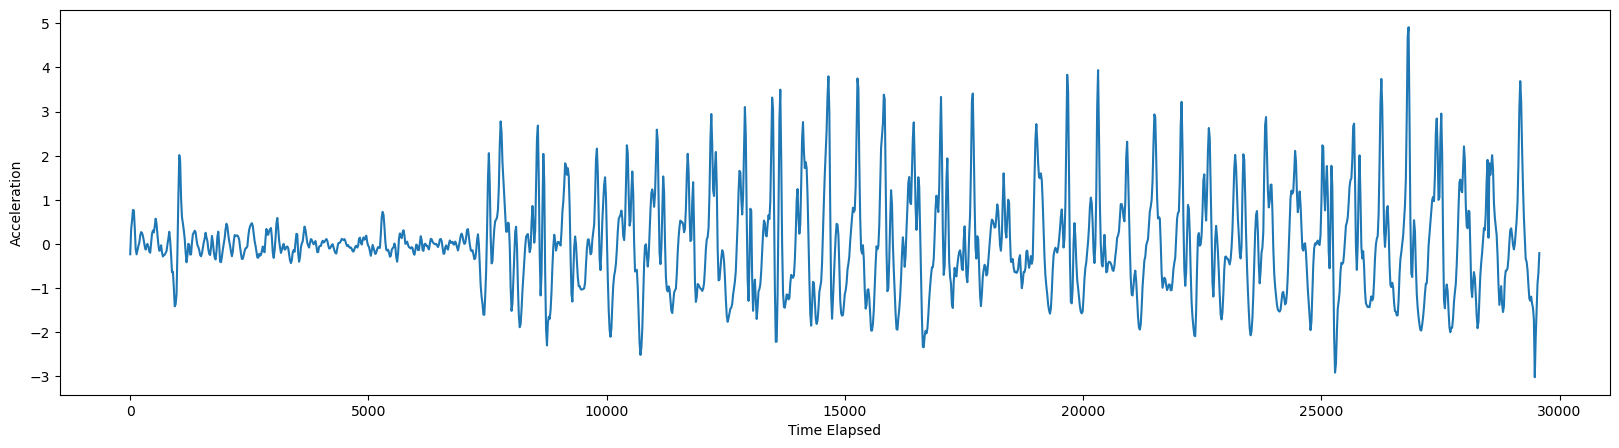

In [13]:
df_accel = df.copy(deep=True)
plt.figure(figsize=(20,5))
plt.plot(df_accel["Time Elapsed"], df_accel["Acceleration"])
plt.xlabel("Time Elapsed")
plt.ylabel("Acceleration")
plt.show()

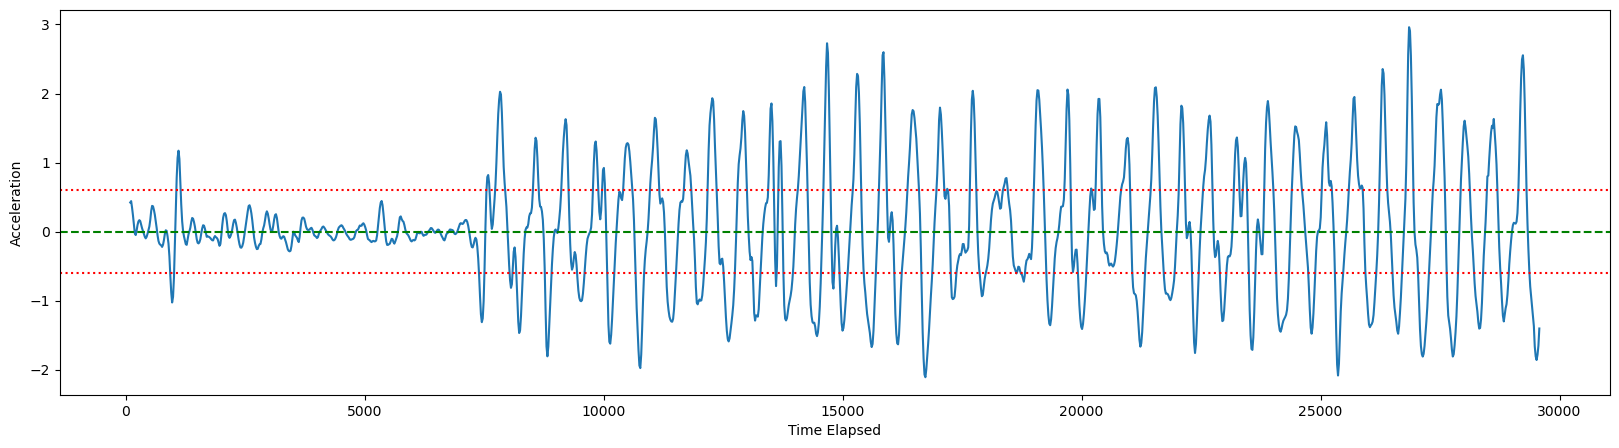

In [14]:
#Do Thresholds
base = 0
margin = 0.6
rolling_mean_window = 6

high_thres = base+margin
low_thres = base-margin

#Smooth the Graph with rolling mean
rolling = df_accel["Acceleration"].rolling(window=rolling_mean_window)
rolling_mean = rolling.mean()
df_accel["Smooth Accel"] = rolling_mean

X = df_accel["Time Elapsed"]
Y = df_accel["Smooth Accel"]

plt.figure(figsize=(20,5))
plt.plot(X, Y)
plt.xlabel("Time Elapsed")
plt.ylabel("Acceleration")
plt.axhline(y=base, color="green", linestyle='--')
plt.axhline(y=high_thres, color="red", linestyle=':')
plt.axhline(y=low_thres, color="red", linestyle=':')
plt.show()

In [15]:
valleys_indexes = (np.diff(np.sign(np.diff(Y))) > 0).nonzero()[0] + 1      # local min
peaks_indexes = (np.diff(np.sign(np.diff(Y))) < 0).nonzero()[0] + 1       # local max
# +1 due to the fact that diff reduces the original index number

v_x = X[valleys_indexes].reset_index(drop=True)#valleys x values
p_x = X[peaks_indexes].reset_index(drop=True)#peaks x values
v_y = Y[valleys_indexes].reset_index(drop=True)#valleys y values
p_y = Y[peaks_indexes].reset_index(drop=True)#valleys y values

#If the first point is a peak, remove that peak and let valleys go first
if p_x[0] < v_x[0]:
    p_x = p_x.drop(index=p_x.index[0], axis=0).reset_index(drop=True)
    p_y = p_y.drop(index=p_y.index[0], axis=0).reset_index(drop=True)
    
detected_steps = []
for i in range(min(len(v_x),len(p_x))):
    v = [v_x[i], v_y[i]]
    p = [p_x[i], p_y[i]] 
    x1 = v[0]
    x2 = p[0]
    y1 = v[1]
    y2 = p[1]
    if y1 < low_thres and y2 > high_thres:
        m = ((y2-y1)/(x2-x1))
        c = -(m*x1)+y1
        detected_steps.append(-c/m)
        #print(f"{v}, {p}, {(-(m*-x1)+(y1))/m}")
        
len(detected_steps)

27

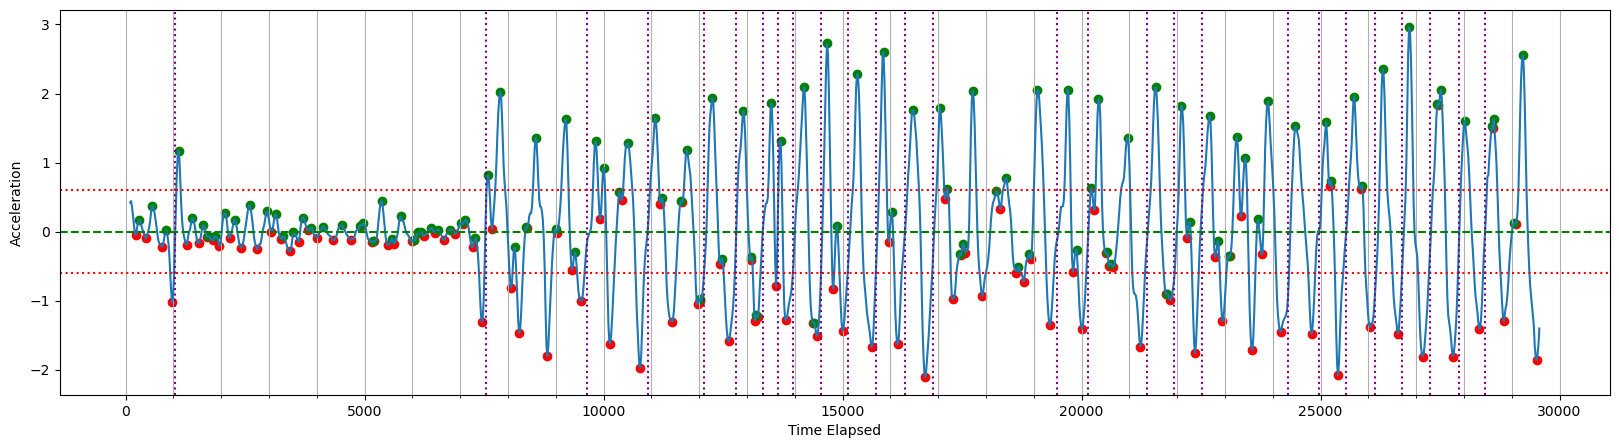

In [16]:
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1, 1, 1)
minor_tick = []
for i in range(0, int(max(p_x)), 1000):
    minor_tick.append(i)
plt.plot(X, Y)
plt.xlabel("Time Elapsed")
plt.ylabel("Acceleration")
ax.set_xticks(minor_tick, minor=True)
plt.grid(axis="x", which="both")
plt.scatter(x=v_x, y=v_y, color="red")
plt.scatter(x=p_x, y=p_y, color="green")
plt.axhline(y=base, color="green", linestyle='--')
plt.axhline(y=high_thres, color="red", linestyle=':')
plt.axhline(y=low_thres, color="red", linestyle=':')
for i in detected_steps:
    plt.axvline(x=i, color="purple", linestyle=":")
plt.show()

In [17]:
step_counter = 0
completed_df["Step Detected"] = False
for i, row in completed_df.iterrows():
    if len(detected_steps) == step_counter:
        break
    #If Step detected at this time point, then
    if row["Time Elapsed"] >= detected_steps[step_counter]:
        completed_df.loc[i, ("Step Detected")]= True
        step_counter += 1
completed_df

,Acceleration,Heading,Timestamp,Wifi,Time Elapsed,Predicted X,Predicted Y,Step Detected
0,-0.232228,0.000000,5.574053e+12,[],0.000000,NaN,NaN,False
1,0.333068,0.073541,5.574072e+12,[],19.057002,NaN,NaN,False
2,0.532064,0.022184,5.574091e+12,[],38.113920,NaN,NaN,False
3,0.772587,-0.093608,5.574110e+12,[],57.171096,NaN,NaN,False
4,0.760338,-0.231243,5.574129e+12,[],76.228112,NaN,NaN,False
...,...,...,...,...,...,...,...,...
1548,-2.128944,-185.977957,5.603553e+12,[],29500.098645,NaN,NaN,False
1549,-1.510123,-185.672361,5.603572e+12,[],29519.155594,NaN,NaN,False
1550,-0.899961,-185.230250,5.603591e+12,[],29538.212582,NaN,NaN,False
1551,-0.658768,-184.659143,5.603610e+12,[],29557.269478,NaN,NaN,False


# Particle Filter

In [18]:
import pandas as pd
import numpy as np
from numpy import random
from numpy.random import uniform
import math
import time
import plotly.express as px
import plotly.graph_objects as go

In [42]:
#Kernel of Particle Filter

#Return array of random particles with 3 columns. X, Y , Heading
def create_uniform_particles(x_min, x_max, y_min, y_max, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_min, x_max, size=N)
    particles[:, 1] = uniform(y_min, y_max, size=N)
    particles[:, 2] = uniform(0, 360, size=N)
    return particles
        
def apply_movement(particles, distance, heading, angle_offset, distance_std, heading_std):
    moved_particles = np.empty((len(particles), 3))
    for i in range(len(particles)):
        #Adding noise
        noisy_distance = random.normal(distance, distance_std)
        noisy_angle = random.normal(0, heading_std)
        
        #New heading direction for particle
        direction = particles[i][2] + heading + noisy_angle
        x = particles[i][0] + (noisy_distance * math.cos(((angle_offset-direction) * math.pi) / 180))
        y = particles[i][1] + (noisy_distance * math.sin(((angle_offset-direction) * math.pi) / 180))
        moved_particles[i] = [x,y,direction]
    return moved_particles


def validate_angle(angle):
    if angle >= 360:
        return angle-360
    elif angle < 0:
        return angle+360
    else:
        return angle
    

def calculate_weights(particles, predicted_location, xRange, yRange, std):
    weights = []
    
    sum = 0
    #Get Sum of distances from all particles
    for particle in particles:
            
        d = distance(particle, predicted_location)
        p = likelihood(d, std)
        if (not is_in_Bounds(particle, xRange, yRange)):
            p = 0

        weights.append(p)
        sum += p
    weights[:] = [x / sum for x in weights]

    #return likelihood for all particles each between 0 and 1, all summing to 1
    return weights

def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def likelihood(distance, std):
    variance = std**2
    return np.exp(-0.5*(distance**2/variance))

def is_in_Bounds(p, xRange, yRange):
    return not(p[0] < xRange[0] or p[0] > xRange[1] or p[1] < yRange[0] or p[1] > yRange[1])
    
    
    
    
def resample(particles, weights, N, xRange, yRange, noise_std):
    new_particles=np.empty((N,3))

    for i in range(N):
        index = random.choice(np.arange(0,len(weights), 1), p=weights)
        x = random.normal(particles[index][0], noise_std)
        y = random.normal(particles[index][1], noise_std)
        while (not is_in_Bounds([x,y], xRange, yRange)):
            x = random.normal(particles[index][0], noise_std)
            y = random.normal(particles[index][1], noise_std)
        
        new_particles[i] = [x,y,particles[index][2]]
    #Return particles that tend towards the weights
    return new_particles

In [43]:
#Function to given necessary constants
def reset(N, x, y, xRange, yRange, step_distance, angle_offset):
    #Create random particles in random location
    particles = create_uniform_particles(xRange[0], xRange[1], yRange[0], yRange[1], N)
    #All weights for particles
    weights = np.array([1/N]*N)
    
    return N, particles, weights, x, y, xRange, yRange, step_distance, angle_offset

def update_steps_location(x ,y ,xCoords, yCoords, dist, heading, angle_offset):
    if (len(xCoords) == 0 and len(yCoords) == 0):
        x += (dist * math.cos((abs(angle_offset-heading) * math.pi) / 180))
        y += (dist * math.sin((abs(angle_offset-heading) * math.pi) / 180))
    else:
        x = xCoords[len(xCoords)-1] + (dist * math.cos(((angle_offset-heading) * math.pi) / 180))
        y = yCoords[len(yCoords)-1] + (dist * math.sin(((angle_offset-heading) * math.pi) / 180))
        
    xCoords.append(x)
    yCoords.append(y)
    return xCoords, yCoords

#Traces are the detected steps and are a reference for the real path
def plot_particles(particles, weights, xRange, yRange):
    fig = px.scatter(x=particles[:,0], y=particles[:,1],size=weights)#size=weights changes size of points
    fig.update_layout(width = 700, height = 500, xaxis_range = xRange, yaxis_range = yRange)
    return fig





#The driver code for particle filter
def particle_filter_driver_code(N, particles, weights, df, x, y, xRange, yRange, step_distance, angle_offset, step_distance_std, heading_std, weights_std, resample_std):
    test_list_x = []
    test_list_y = []
    Real_path_x = [3, -3, -3, 3, 3, -3, -3, 3, 3]
    Real_path_y = [-3, -3, 0, 0, -3, -3, 0, 0, -3]
    #Coords of where steps were detected
    xTraces = []
    yTraces = []

    last_step_heading = 0
    for i, row in df.iterrows():
        #Control Data
        #If Step detected at this time point, then apply movement
        if row["Step Detected"] == True:
            particles = apply_movement(particles, step_distance, row["Heading"]-last_step_heading, angle_offset, step_distance_std, heading_std)
            last_step_heading = row["Heading"]
            #test_list_x.append(particles[0, 0])
            #test_list_y.append(particles[0,1])
            
            #Update traces with next detected step
            xTraces, yTraces = update_steps_location(x, y, xTraces, yTraces, step_distance, row["Heading"], angle_offset)
        else: #If no steps detected, update particles' headings but not distance moved.
            last_step_heading = row["Heading"]
            particles = apply_movement(particles, 0, row["Heading"]-last_step_heading, angle_offset, 0, heading_std)
        #Observation Data
        #If predicted coords are available then apply them
        if (not math.isnan(row["Predicted X"])):
            pred_x = row["Predicted X"]
            pred_y = row["Predicted Y"]
            test_list_x.append(pred_x)
            test_list_y.append(pred_y)
            
            
            
            ##Calculate Weights for current particles, then plot how well the weights fit, then resample for next iteration
            print(f"Predicted Coords: {pred_x}, {pred_y}")
            weights = calculate_weights(particles, [pred_x, pred_y], xRange, yRange, weights_std)
            
            #Plot particles
            fig = plot_particles(particles, weights, xRange, yRange)
            fig.add_trace(go.Scatter(x=xTraces, y=yTraces, mode='lines+markers', name="Detected Steps"))
            fig.add_trace(go.Scatter(x=[pred_x], y=[pred_y], mode='lines+markers', name="Observation Data"))
            #fig.add_trace(go.Scatter(x=Real_path_x, y=Real_path_y, mode='lines+markers', name="Real Path"))
            fig.add_trace(go.Scatter(x=[3], y=[-3], mode='lines+markers', name="Starting Position"))
            #fig.add_trace(go.Scatter(x=test_list_x, y=test_list_y, mode='lines+markers'))
            fig.show()
            
            #Resample based on current weights
            particles = resample(particles, weights, N, xRange, yRange, resample_std)
            
            
            #Slowly converge the particles
            if (weights_std > 0.25):
                weights_std = weights_std - 0.3
            if (resample_std > 0.25):
                resample_std = resample_std - 0.3
                

In [44]:
def create_articial_observation_data(x, y, heading_list, detected_steps_list, step_distance, angle_offset, step_distance_std, heading_std):
    if (len(heading_list) != len(detected_steps_list)):
        return
    observation_data_x = [x]
    observation_data_y = [y]
    for i in range(1, len(heading_list)):
        #Adding noise
        noisy_distance = 0
        if (detected_steps_list[i] == True):
            noisy_distance = random.normal(step_distance, step_distance_std)
        noisy_angle = random.normal(0, heading_std)
        
        direction = heading_list[i] + noisy_angle
        x = observation_data_x[i-1] + (noisy_distance * math.cos(((angle_offset-direction) * math.pi) / 180))
        y = observation_data_y[i-1] + (noisy_distance * math.sin(((angle_offset-direction) * math.pi) / 180))


        observation_data_x.append(x)
        observation_data_y.append(y)

    # Artifically add in null values to reduce quantity of observation data
    for i in range(1, len(observation_data_x)):
        if (not i % 3 == 0):
            observation_data_x[i] = np.nan
            observation_data_y[i] = np.nan
    return observation_data_x, observation_data_y



N, particles, weights, x, y, xRange, yRange, step_distance, angle_offset = reset(
    100, 4, -2.5, np.array([-10,10]), np.array([-10,10]), 0.6, 180)
#particles = create_uniform_particles(3.5, 4.5, -2, -3, N)
step_distance_std = 0.1
heading_std = 1
#These two standard deviations can be made really small so you can see the control data actually 
#playing a part and the fact that the particles need apply_movement() (i.e the particles at the start don't resample around the observation data, they tend to follow it closely until a particle gets lucky so the rest can also converge)
weights_std = 2
resample_std = 2


test_detected_steps = [False, True, True, True, True, True, False, True, False, True, True, True, True, True, True, False, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True]#len = 15
#test_heading = [0, 0, 0 ,-30, -60, -90, -120, -160, -160, -180, -180, -200, -210, -230, -260]
test_heading = [0, 0, 0 ,-30, -30, -30, -30, -45, -50, -60, -60 , -50, -40, -30, -20, 0, 0, 0 ,30, 30, 30, 30, 45, 50, 60, 60 , 70, 80, 90, 100, 100, 100]
test_observation_x_data, test_observation_y_data = create_articial_observation_data(x ,y ,test_heading, test_detected_steps, step_distance, angle_offset, step_distance_std, heading_std)

Artificial_data_df = pd.DataFrame()
Artificial_data_df["Predicted X"] = test_observation_x_data
Artificial_data_df["Predicted Y"] = test_observation_y_data
Artificial_data_df["Step Detected"] = test_detected_steps
Artificial_data_df["Heading"] = test_heading

#Plot intial particles
fig = plot_particles(particles, weights, xRange, yRange)
fig.show()

particle_filter_driver_code(N, particles, weights, Artificial_data_df, x, y, xRange, yRange, step_distance, angle_offset, step_distance_std, heading_std, weights_std, resample_std)
Artificial_data_df

Predicted Coords: 4.0, -2.5


Predicted Coords: 2.338849877396269, -2.8300675300994045


Predicted Coords: 1.4735884114811282, -3.3415391508309624


Predicted Coords: 0.7340682027744216, -4.303064147868585


Predicted Coords: -0.17447376214980231, -5.434127405042164


Predicted Coords: -1.3251104768866329, -5.9700278397755335


Predicted Coords: -2.9103329991051377, -5.646778166853853


Predicted Coords: -4.000984116479453, -5.042634847564883


Predicted Coords: -4.738076527142469, -4.065680618598191


Predicted Coords: -5.340078633440167, -2.3556869284302753


Predicted Coords: -5.151990074727162, -0.5498620081277731


,Predicted X,Predicted Y,Step Detected,Heading
0,4.000000,-2.500000,False,0
1,NaN,NaN,True,0
2,NaN,NaN,True,0
3,2.338850,-2.830068,True,-30
4,NaN,NaN,True,-30
5,NaN,NaN,True,-30
6,1.473588,-3.341539,False,-30
7,NaN,NaN,True,-45
8,NaN,NaN,False,-50
9,0.734068,-4.303064,True,-60


In [23]:
fig = go.Figure(data=go.Scatter(x=xCoords, y=yCoords, mode='lines+markers'))
fig.update_layout(width = 700, height = 500, xaxis_range=[-10,10], yaxis_range=[-10,10],  title = "Samples from prior")
fig.show()

NameError: name 'xCoords' is not defined

In [ ]:
-60--60